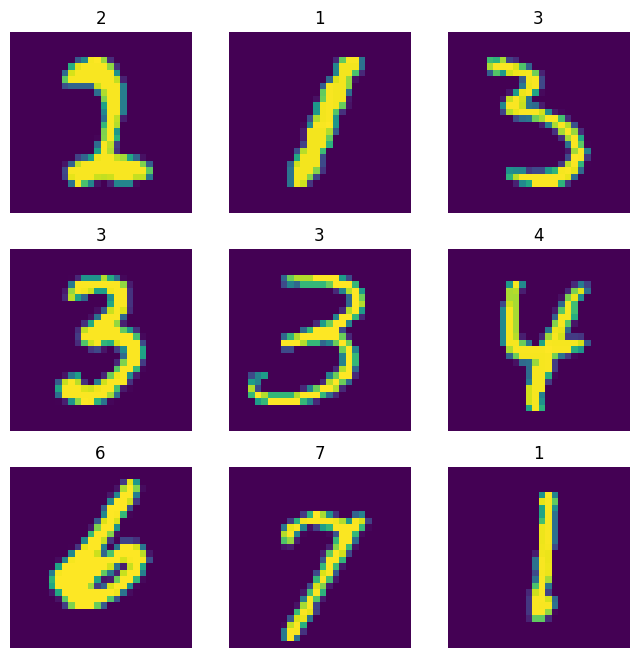

In [7]:
# resnet模型实现手写体识别，数据集使用MNIST

#准备数据集
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets, models, transforms
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
import numpy
from PIL import Image
# transform = transforms.Compose([
#     transforms.Grayscale(num_output_channels=3),#3为三通道，1为单通道
#     transforms.ToTensor()
#     ])
training_data = datasets.MNIST(
    root="hand_writing_data",
    train=True,
    download=True,
    transform=ToTensor()
)
test_data = datasets.MNIST(
    root="hand_writing_data",
    train=False,
    download=True,
    transform=ToTensor()
)

train_dataloader = DataLoader(training_data, batch_size=64)
test_dataloader = DataLoader(test_data, batch_size=64)
labels_map = {
    0: "0",
    1: "1",
    2: "2",
    3: "3",
    4: "4",
    5: "5",
    6: "6",
    7: "7",
    8: "8",
    9: "9",
}
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(training_data), size=(1,)).item() #随机取出一张图片，并获得图片id
    img, label = training_data[sample_idx] #数据收集，img存训练数据张量，label存其对应的标签如trouser对应1
    figure.add_subplot(rows, cols, i) #将figure划分为3*3网络，并在指定格子创建Axes，之后可在此axes中绘制图形
    plt.title(labels_map[label])
    plt.axis("off")
    # img=torch.Tensor.transpose(img,0,2)
    plt.imshow(img.squeeze()) #, cmap="plasma"将img张量的值以图片展示，cmap热图
plt.show()

In [8]:
#模型建立
import resnet1
device = "cuda" if torch.cuda.is_available() else "cpu"
# model = models.resnet50(num_classes=10).to(device)
model = resnet1.resnet50(num_classes=10).to(device)

In [9]:
# 超参数
learning_rate = 1e-3 #学习率，每个纪元更新模型参数的数量。较小的值会导致学习速度变慢，而较大的值可能会导致训练期间不可预测的行为。
batch_size = 64 #批量大小，更新参数前通过网络传播的样本数
epochs = 1 #纪元数，迭代数据集的次数

In [10]:
# 优化循环
# 训练循环，遍历训练数据集并尝试收敛到最佳参数。
def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    for batch, (features, targets) in enumerate(dataloader):
        # 每次迭代中，计算预测值与损失
        # pred = model(X.to(device))
        # loss = loss_fn(pred, y.to(device))
        pred, probas = model(features.to(device))
        loss = loss_fn(pred, targets.to(device))

        # 优化过程，收集误差相对于其参数的导数
        optimizer.zero_grad() #重置模型参数梯度，防止重复计算
        loss.backward() #反向传播预测损失，获得损失梯度
        optimizer.step() #利用损失梯度调整参数

        if batch % 100== 0:
            loss, current = loss.item(), batch * len(features)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

# 测试循环，循环测试数据集以检查模型性能是否正在提高。
def test_loop(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    with torch.no_grad():
        for features, targets in dataloader:
            features = features.cuda()
            pred, probas = model(features.to(device))
            test_loss += loss_fn(pred, targets.to(device)).item()
            correct += (pred.argmax(1) == targets.to(device)).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

In [11]:
# 损失函数和优化器
loss_fn = nn.CrossEntropyLoss()
# 使用梯度下降，优化调整模型参数减少模型误差
optimizer = torch.optim.Adam(params=model.parameters(), lr=learning_rate)

# 训练开始
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(train_dataloader, model, loss_fn, optimizer)
    test_loop(test_dataloader, model, loss_fn)
print("Done!")

Epoch 1
-------------------------------
loss: 2.585874  [    0/60000]
loss: 0.265320  [ 6400/60000]
loss: 0.055180  [12800/60000]
loss: 0.143749  [19200/60000]
loss: 0.211121  [25600/60000]
loss: 0.120838  [32000/60000]
loss: 0.062789  [38400/60000]
loss: 0.173206  [44800/60000]
loss: 0.299648  [51200/60000]
loss: 1.028696  [57600/60000]
Test Error: 
 Accuracy: 95.6%, Avg loss: 0.222327 

Done!


TypeError: Invalid shape (1, 28, 28) for image data

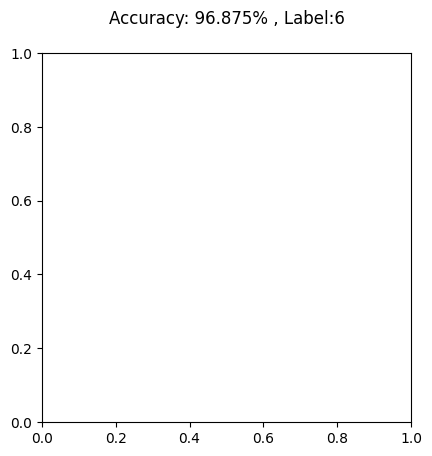

In [12]:
# 单张图片预测
# 读取单张图片
# sample_idx = torch.randint(len(next(iter(test_dataloader))), size=(1,)).item()
test_features, test_labels = next(iter(test_dataloader))
# sample_idx = torch.randint(len(test_features)), size=(1,)).item()
img = test_features[0]
label = test_labels[0]
# 模型预测
model.eval()
correct = 0
with torch.no_grad():
    pred,probas = model(test_features.to(device))
    pre_label = (pred.argmax(1) == label.to(device)).type(torch.float).sum().item()
    correct += (pred.argmax(1) == test_labels.to(device)).type(torch.float).sum().item()
correct /= batch_size
# 可视化结果
plt.title("Accuracy: {}% , Label:{}\n".format(100*correct, int(pre_label)))
# img=torch.Tensor.transpose(img,0,2)
plt.imshow(img)
plt.show()
